<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/DL/C06_20240515_Transferencia_de_aprendizaje_CasoFlores_inceptioV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub

[TensorFlow Hub](http://tensorflow.org/hub) es un repositorio en línea de modelos de TensorFlow ya entrenados que puedes usar.
Estos modelos se pueden utilizar tal cual o se pueden utilizar para el aprendizaje por transferencia.

El aprendizaje por transferencia es un proceso en el que se toma un modelo entrenado existente y se lo amplía para realizar trabajo adicional. Esto implica dejar la mayor parte del modelo sin cambios, mientras se agregan y reentrenan las capas finales, para obtener un conjunto diferente de posibles resultados.

Aquí puede ver todos los modelos disponibles en [TensorFlow Module Hub](https://tfhub.dev/).

Antes de iniciar este Colab, debe restablecer el entorno de Colab seleccionando `Runtime -> Reset all runtimes...` en el menú de arriba.

# Importar


Algunas importaciones normales que hemos visto antes. El nuevo importa tensorflow_hub, que este Colab hará un uso intensivo.

In [1]:
import tensorflow as tf
# TensorFlow proporciona una variedad de herramientas y funciones para construir y entrenar modelos de machine learning.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# TODO: descargar el conjunto de datos de flores usando conjuntos de datos de TensorFlow

En la celda siguiente, descargará el conjunto de datos de Flowers utilizando conjuntos de datos de TensorFlow. Si observa la [documentación de conjuntos de datos de TensorFlow] (https://www.tensorflow.org/datasets/datasets#tf_flowers) verá que el nombre del conjunto de datos de Flowers es `tf_flowers`. También puede ver que este conjunto de datos solo se divide en un conjunto de ENTRENAMIENTO. Por lo tanto, tendrá que usar `tfds.splits` para dividir este conjunto de entrenamiento en un `training_set` y un `validation_set`. Haga una división `[70, 30]` de modo que 70 corresponda al `training_set` y 30 al `validation_set`. Luego cargue el conjunto de datos `tf_flowers` usando `tfds.load`. Asegúrese de que la función `tfds.load` utilice todos los parámetros que necesita y también asegúrese de que devuelva la información del conjunto de datos, para que podamos recuperar información sobre los conjuntos de datos.


In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',  # Carga el conjunto de datos 'tf_flowers' desde TensorFlow Datasets (TFDS).
    split=['train[:70%]', 'train[70%:]'],  # Divide el conjunto de datos en un 70% para entrenamiento y un 30% para validación.
    with_info=True,  # Incluye información adicional sobre el conjunto de datos, como el número de ejemplos y clases.
    as_supervised=True  # Carga los datos en un formato (imagen, etiqueta) para facilitar el entrenamiento supervisado.
)
# Carga y divide el conjunto de datos 'tf_flowers' en conjuntos de entrenamiento y validación.
# También obtiene información adicional sobre el conjunto de datos, como el número de ejemplos y clases disponibles en 'dataset_info'.


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# TODO: Imprimir información sobre el conjunto de datos de flores

Ahora que ha descargado el conjunto de datos, use la información del conjunto de datos para imprimir la cantidad de clases en el conjunto de datos y también escriba algún código que cuente cuántas imágenes tenemos en los conjuntos de entrenamiento y validación.

In [5]:
num_classes = dataset_info.features['label'].num_classes  # Obtiene el número de clases en el conjunto de datos.

num_training_examples = 0  # Inicializa el contador para el número total de ejemplos de entrenamiento.
num_validation_examples = 0  # Inicializa el contador para el número total de ejemplos de validación.

for example in training_set:  # Itera sobre los ejemplos en el conjunto de entrenamiento y cuenta el número total de ejemplos de entrenamiento.
    num_training_examples += 1

for example in validation_set:  # Itera sobre los ejemplos en el conjunto de validación y cuenta el número total de ejemplos de validación.
    num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))  # Imprime el número total de clases en el conjunto de datos.
print('Total Number of Training Images: {}'.format(num_training_examples))  # Imprime el número total de ejemplos de entrenamiento.
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))  # Imprime el número total de ejemplos de validación.

# En este bloque de código, se calcula y muestra el número total de clases, ejemplos de entrenamiento y ejemplos de validación en el conjunto de datos 'tf_flowers'.

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Las imágenes del conjunto de datos de Flowers no son todas del mismo tamaño.

In [6]:
for i, example in enumerate(training_set.take(5)):  # Itera sobre los primeros 5 ejemplos del conjunto de entrenamiento.
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
    # Imprime el número de la imagen (incrementado en 1 para hacerlo más legible), la forma (shape) de la imagen y su etiqueta correspondiente.

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# TODO: reformatear imágenes y crear lotes

En la celda siguiente, cree una función que vuelva a formatear todas las imágenes a la resolución esperada por MobileNet v2 (224, 224) y las normalice. La función debe tomar una `image` y una `label` como argumentos y debe devolver la nueva `image` y la `label` correspondiente. Luego cree lotes de capacitación y validación de tamaño `32`.

In [7]:
IMAGE_RES = 224  # Establece la resolución de las imágenes a 224x224 píxeles.

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
      # Redimensiona la imagen a las dimensiones especificadas y normaliza los valores de píxeles a un rango entre 0 y 1.
    return image, label  # Devuelve la imagen formateada y su etiqueta correspondiente.

BATCH_SIZE = 32  # Establece el tamaño del lote (batch size) para el entrenamiento y la validación.

train_batches = training_set.shuffle(num_training_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de entrenamiento: mezcla los ejemplos de entrenamiento, aplica el formato de imagen definido,
#agrupa los ejemplos en lotes del tamaño especificado y los almacena en memoria para el acceso eficiente durante el entrenamiento.

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de validación: aplica el formato de imagen definido, agrupa los ejemplos en lotes
#del tamaño especificado y los almacena en memoria para su uso durante la validación del modelo.

# En este bloque de código, se define una función de formateo de imagen y se preparan lotes de entrenamiento y
# validación para su uso durante el entrenamiento del modelo de clasificación de imágenes.


# Realice un aprendizaje por transferencia simple con TensorFlow Hub

Ahora usemos TensorFlow Hub para realizar Transfer Learning. Recuerde, en el aprendizaje por transferencia reutilizamos partes de un modelo ya entrenado y cambiamos la capa final, o varias capas, del modelo, y luego volvemos a entrenar esas capas en nuestro propio conjunto de datos.

### TODO: Crear un extractor de funciones
En la celda siguiente, cree un `feature_extractor` usando MobileNet v2. Recuerde que el modelo parcial de TensorFlow Hub (sin la capa de clasificación final) se denomina vector de características. Vaya a la [documentación de TensorFlow Hub](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) para ver una lista de vectores de características disponibles. Haga clic en `tf2-preview/mobilenet_v2/feature_vector`. Lea la documentación y obtenga la "URL" correspondiente para obtener el vector de características de MobileNet v2. Finalmente, cree un `feature_extractor` usando `hub.KerasLayer` con el parámetro `input_shape` correcto.

In [8]:
URL = "https://www.kaggle.com/models/google/inception-v3/TensorFlow2/classification/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
# Carga una capa de extracción de características de MobileNetV2 desde la URL especificada en TensorFlow Hub.
# La capa está configurada para aceptar imágenes de tamaño (IMAGE_RES, IMAGE_RES, 3) como entrada, donde 3 representa los canales de color RGB.


### TODO: congelar el modelo previamente entrenado

En la celda siguiente, congele las variables en la capa del extractor de características, de modo que el entrenamiento solo modifique la capa del clasificador final.

In [9]:
feature_extractor.trainable = False
# Establece el atributo 'trainable' de la capa de extracción de características en False.
# Esto significa que los pesos de la capa no se actualizarán durante el entrenamiento del modelo completo.


### TODO: Adjuntar un encabezado de clasificación

En la celda siguiente, cree un modelo `tf.keras.Sequential` y agregue el modelo previamente entrenado y la nueva capa de clasificación. Recuerde que la capa de clasificación debe tener la misma cantidad de clases que nuestro conjunto de datos de Flores. Finalmente imprima un resumen del modelo secuencial.

In [10]:
model = tf.keras.Sequential([
    feature_extractor,  # Agrega la capa de extracción de características (MobileNetV2) al modelo.
    layers.Dense(num_classes)  # Agrega una capa densa con 'num_classes' unidades para la clasificación multiclase.
])

model.summary()
# Muestra un resumen del modelo, incluyendo la arquitectura de las capas y el número de parámetros entrenables.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 23858843 (91.01 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 23853833 (91.00 MB)
_________________________________________________________________


### TODO: Entrenar el modelo

En la celda siguiente, entrene este modelo como cualquier otro, llamando primero a `compile` y luego a `fit`. Asegúrese de utilizar los parámetros adecuados al aplicar ambos métodos. Entrena el modelo durante solo 6 épocas.

In [11]:
model.compile(
    optimizer='adam',  # Configura el optimizador Adam para el entrenamiento del modelo.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # Utiliza la entropía cruzada categórica como función de pérdida para problemas de clasificación.
    metrics=['accuracy']
    # Utiliza la precisión como métrica para evaluar el rendimiento del modelo durante el entrenamiento.
)

EPOCHS = 6  # Establece el número de épocas para entrenar el modelo.

history = model.fit(
    train_batches,  # Utiliza el lote de entrenamiento para el entrenamiento del modelo.
    epochs=EPOCHS,  # Número de épocas para entrenar el modelo.
    validation_data=validation_batches  # Utiliza el lote de validación para evaluar
    #el modelo después de cada época de entrenamiento.
)


Epoch 1/6
81/81 [==============================] - 23s 149ms/step - loss: 0.9064 - accuracy: 0.7135 - val_loss: 0.5663 - val_accuracy: 0.8038
Epoch 2/6
81/81 [==============================] - 8s 97ms/step - loss: 0.4769 - accuracy: 0.8388 - val_loss: 0.4868 - val_accuracy: 0.8220
Epoch 3/6
81/81 [==============================] - 8s 97ms/step - loss: 0.3694 - accuracy: 0.8700 - val_loss: 0.4576 - val_accuracy: 0.8356
Epoch 4/6
81/81 [==============================] - 8s 98ms/step - loss: 0.3104 - accuracy: 0.8902 - val_loss: 0.4377 - val_accuracy: 0.8456
Epoch 5/6
81/81 [==============================] - 8s 96ms/step - loss: 0.2749 - accuracy: 0.9042 - val_loss: 0.4384 - val_accuracy: 0.8501
Epoch 6/6
81/81 [==============================] - 8s 96ms/step - loss: 0.2488 - accuracy: 0.9097 - val_loss: 0.4423 - val_accuracy: 0.8520


Puede ver que obtenemos ~90% de precisión de validación con solo 6 épocas de entrenamiento, lo cual es absolutamente asombroso. Esta es una gran mejora con respecto al modelo que creamos en la lección anterior, donde pudimos obtener ~94 % de precisión con 6 épocas de entrenamiento. La razón de esta diferencia es que MobileNet v2 fue diseñado cuidadosamente durante mucho tiempo por expertos y luego entrenado en un conjunto de datos masivo (ImageNet).

# TODO: Trazar gráficos de entrenamiento y validación

En la celda siguiente, trace los gráficos de precisión/pérdida de entrenamiento y validación.

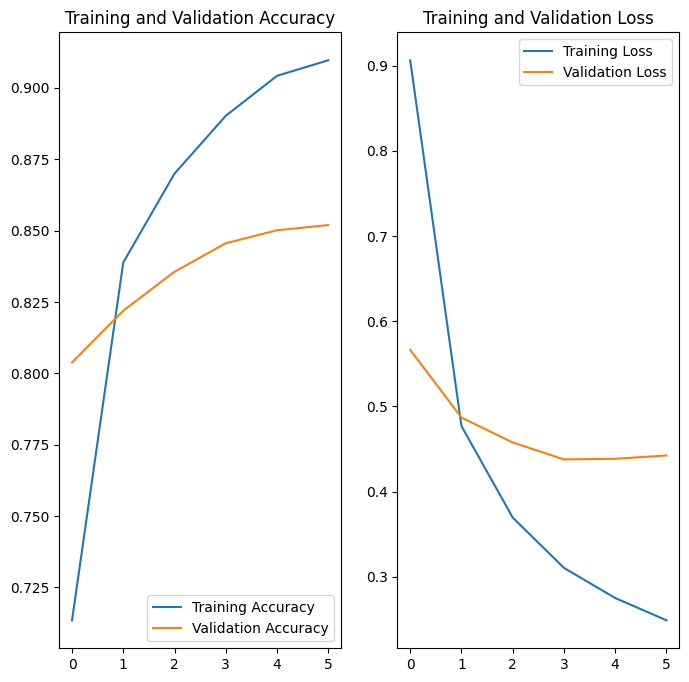

In [12]:
acc = history.history['accuracy']  # Obtiene la precisión del entrenamiento en cada época.
val_acc = history.history['val_accuracy']  # Obtiene la precisión de la validación en cada época.

loss = history.history['loss']  # Obtiene la pérdida del entrenamiento en cada época.
val_loss = history.history['val_loss']  # Obtiene la pérdida de la validación en cada época.

epochs_range = range(EPOCHS)  # Crea un rango de épocas para utilizar en el gráfico.

plt.figure(figsize=(8, 8))  # Establece el tamaño de la figura para mostrar las gráficas de precisión y pérdida.

# Gráfico de precisión del entrenamiento y validación.
plt.subplot(1, 2, 1)  # Crea una subtrama en la primera posición de una cuadrícula de 1 fila y 2 columnas.
plt.plot(epochs_range, acc, label='Training Accuracy')  # Dibuja la precisión del entrenamiento.
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Dibuja la precisión de la validación.
plt.legend(loc='lower right')  # Muestra la leyenda en la esquina inferior derecha.
plt.title('Training and Validation Accuracy')  # Establece el título del gráfico.

# Gráfico de pérdida del entrenamiento y validación.
plt.subplot(1, 2, 2)  # Crea una subtrama en la segunda posición de la cuadrícula.
plt.plot(epochs_range, loss, label='Training Loss')  # Dibuja la pérdida del entrenamiento.
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Dibuja la pérdida de la validación.
plt.legend(loc='upper right')  # Muestra la leyenda en la esquina superior derecha.
plt.title('Training and Validation Loss')  # Establece el título del gráfico.

plt.show()  # Muestra los gráficos de precisión y pérdida.


Lo que resulta un poco curioso aquí es que el rendimiento de la validación es mejor que el rendimiento del entrenamiento, desde el principio hasta el final de la ejecución.

Una razón para esto es que el rendimiento de la validación se mide al final de la época, pero el rendimiento del entrenamiento son los valores promedio a lo largo de la época.

Sin embargo, la razón más importante es que estamos reutilizando una gran parte de MobileNet que ya está entrenado en imágenes de flores.

# TODO: Verificar predicciones

En la celda siguiente, obtenga los nombres de las etiquetas de la información del conjunto de datos y conviértalos en una matriz NumPy. Imprima la matriz para asegurarse de tener los nombres de etiqueta correctos.

In [13]:
class_names = np.array(dataset_info.features['label'].names)
# Obtiene las etiquetas de clase del conjunto de datos y las almacena en un array de NumPy llamado 'class_names'.

print(class_names)
# Imprime las etiquetas de clase del conjunto de datos 'tf_flowers'.
#Estas etiquetas representan las diferentes categorías a las que pertenecen las imágenes, como 'rosa', 'diente de león', etc.


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### TODO: crear un lote de imágenes y hacer predicciones

En la siguiente celda, use la función `next()` para crear un `image_batch` y su correspondiente `label_batch`. Convierta tanto `image_batch` como `label_batch` en matrices numpy usando el método `.numpy()`. Luego use el método `.predict()` para ejecutar el lote de imágenes a través de su modelo y hacer predicciones. Luego use la función `np.argmax()` para obtener los índices de la mejor predicción para cada imagen. Finalmente convierta los índices de las mejores predicciones en nombres de clases.

In [14]:
image_batch, label_batch = next(iter(train_batches))
# Obtiene un lote de imágenes y etiquetas del conjunto de entrenamiento utilizando la función next(iter(train_batches)).

image_batch = image_batch.numpy()  # Convierte el lote de imágenes a un array de NumPy.
label_batch = label_batch.numpy()  # Convierte el lote de etiquetas a un array de NumPy.

predicted_batch = model.predict(image_batch)  # Realiza predicciones sobre el lote de imágenes utilizando el modelo.
predicted_batch = tf.squeeze(predicted_batch).numpy()  # Elimina las dimensiones adicionales del array resultante y lo convierte a un array de NumPy.

predicted_ids = np.argmax(predicted_batch, axis=-1)  # Obtiene los índices de las clases predichas para cada imagen.
predicted_class_names = class_names[predicted_ids]  # Obtiene los nombres de las clases predichas a partir de los índices utilizando las etiquetas del conjunto de datos.

print(predicted_class_names)
# Imprime los nombres de las clases predichas para el lote de imágenes del conjunto de datos de entrenamiento.


1/1 [==============================] - 1s 748ms/step
['dandelion' 'sunflowers' 'roses' 'dandelion' 'roses' 'tulips' 'dandelion'
 'dandelion' 'sunflowers' 'sunflowers' 'tulips' 'sunflowers' 'dandelion'
 'daisy' 'dandelion' 'dandelion' 'daisy' 'tulips' 'roses' 'tulips' 'daisy'
 'dandelion' 'sunflowers' 'roses' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'tulips' 'dandelion' 'dandelion' 'dandelion']


### TODO: Imprimir etiquetas verdaderas e índices previstos

En la celda siguiente, imprima las etiquetas verdaderas y los índices de las etiquetas previstas.

In [15]:
print("Labels:           ", label_batch)  # Imprime las etiquetas reales (ground truth) del lote de imágenes.
print("Predicted labels: ", predicted_ids)  # Imprime las etiquetas predichas por el modelo para el lote de imágenes.


Labels:            [0 3 4 0 4 4 0 0 3 3 2 3 0 1 0 0 1 2 4 2 1 0 3 4 0 0 0 0 4 0 0 0]
Predicted labels:  [0 3 4 0 4 2 0 0 3 3 2 3 0 1 0 0 1 2 4 2 1 0 3 4 0 0 0 0 2 0 0 0]


# Predicciones del modelo de trama

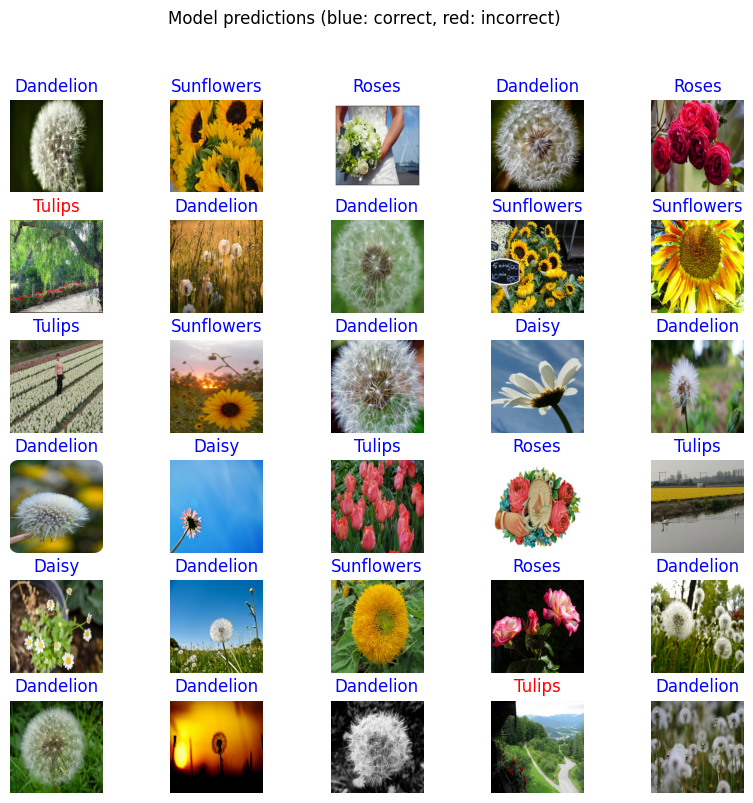

In [16]:
plt.figure(figsize=(10, 9))  # Establece el tamaño de la figura para mostrar las imágenes y las predicciones.

for n in range(30):  # Itera sobre los primeros 30 ejemplos del lote de imágenes.
    plt.subplot(6, 5, n+1)  # Crea subtramas en una cuadrícula de 6 filas y 5 columnas.
    plt.subplots_adjust(hspace=0.3)  # Ajusta el espaciado vertical entre las subtramas.

    plt.imshow(image_batch[n])  # Muestra la imagen en la subtrama actual.
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
     # Determina el color del título según si la predicción es correcta o incorrecta.
    plt.title(predicted_class_names[n].title(), color=color)
    # Establece el título de la subtrama con la clase predicha para la imagen, resaltando las predicciones incorrectas en rojo.
    plt.axis('off')  # Desactiva los ejes para una mejor presentación visual.

_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
# Establece el título principal de la figura para indicar las predicciones del modelo y resaltar las predicciones incorrectas en rojo.


# TODO: Realizar transferencia de aprendizaje con el modelo inicial

1.   Elemento de lista
2.   Elemento de lista



Vaya a la [documentación de TensorFlow Hub] (https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) y haga clic en `tf2-preview/inception_v3/feature_vector`. Este vector de características corresponde al modelo Inception v3. En las celdas siguientes, utilice el aprendizaje por transferencia para crear una CNN que utilice Inception v3 como modelo previamente entrenado para clasificar las imágenes del conjunto de datos de Flowers. Tenga en cuenta que Inception toma como entrada imágenes de 299 x 299 píxeles. Compare la precisión que obtiene con Inception v3 con la precisión que obtuvo con MobileNet v2.

In [17]:
IMAGE_RES = 299  # Establece la resolución de las imágenes a 299x299 píxeles para utilizar el modelo InceptionV3.

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)  # Carga y divide el conjunto de datos 'tf_flowers' en conjuntos de entrenamiento y validación.

train_batches = training_set.shuffle(num_training_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de entrenamiento utilizando la función de formateo de imagen definida anteriormente.

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de validación utilizando la función de formateo de imagen definida anteriormente.

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)
 # Carga la capa de extracción de características del modelo InceptionV3 desde TensorFlow Hub y la fija como no entrenable.

model_inception = tf.keras.Sequential([
  feature_extractor,  # Agrega la capa de extracción de características InceptionV3 al modelo.
  tf.keras.layers.Dense(num_classes)  # Agrega una capa densa con 'num_classes' unidades para la clasificación multiclase.
])

model_inception.summary()
# Muestra un resumen del modelo InceptionV3, incluyendo la arquitectura de las capas
 #y el número de parámetros entrenables y no entrenables.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [18]:
IMAGE_RES = 299  # Establece la resolución de las imágenes a 299x299 píxeles para utilizar el modelo InceptionV3.

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)  # Carga y divide el conjunto de datos 'tf_flowers' en conjuntos de entrenamiento y validación.

train_batches = training_set.shuffle(num_training_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de entrenamiento utilizando la función de formateo de imagen definida anteriormente.

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
# Prepara lotes de validación utilizando la función de formateo de imagen definida anteriormente.

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)  # Carga la capa de extracción de características del modelo InceptionV3 desde TensorFlow Hub y la fija como no entrenable.

model_inception = tf.keras.Sequential([
  feature_extractor,  # Agrega la capa de extracción de características InceptionV3 al modelo.
  tf.keras.layers.Dense(num_classes)  # Agrega una capa densa con 'num_classes' unidades para la clasificación multiclase.
])

model_inception.summary()
# Muestra un resumen del modelo InceptionV3, incluyendo la arquitectura de las capas y el número de parámetros entrenables y no entrenables.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
